# Homework 2

**COPPE/UFRJ - Programa de Engenharia Elétrica (PEE)**

**Course:** COE841 - Special Topics in Autonomous Systems  
**Based on:** *Probabilistic Robotics* by Thrun, Burgard, and Fox (2006)  
**Student:** *Danilo Paes* and *Jonas Ulbrich*  
**Date:** August 2025

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from IPython.display import Image
from skimage.draw import line_aa
from numpy.random import default_rng
from matplotlib.animation import FuncAnimation

# Auxiliary functions and classes

## General Utils
### Float equality
In the numeric domain the equality between float is to be tested with a given tolerance to be able to compensate for discretization artefacts and for the simple reason that the equality of two floating point numbers results in an infinitesimal probability!
### Angles
It is crucial to have a standard way to handle angles and this is best done by defining a helper class which handles all operations related to angles in a consistent way.
The defined `Angle` class is instantiated by providing a value in degrees. This value is then normalized  so that the value lies within $]-180°, 180°]$. Under the hood the value is stored in radiants and is implemented by overloading the float basic type. It provides an abstraction of the `arctan2` function to be able to work with variables of the type `Angle` only!
### Pose
The `Pose` class is a simple data structure that represents the robot’s state in 2D space:

- `x`: horizontal position
- `y`: vertical position
- `orientation`: heading angle (in radians), assuming the standard trigonometric direction, i.e., counterclockwise from the positive x-axis.

In [12]:
def are_equal(a: float, b: float, tol: float=1e-9):
    return abs(a - b) < tol

class Angle(float):
    def __new__(cls, degrees):
        # Normalize to ]-180, 180]
        normalized_deg = degrees % 360

        if normalized_deg > 180:
            normalized_deg -= 360

        return super().__new__(cls, np.deg2rad(normalized_deg))

    @property
    def degrees(self):
        return np.rad2deg(self)

    @property
    def radians(self):
        return float(self)

    # --- Construction from radians ---
    @staticmethod
    def from_radians(radians_value):
        degrees = np.rad2deg(radians_value)
        return Angle(degrees)

    @staticmethod
    def arctan2(dy, dx):
        return Angle.from_radians(np.arctan2(dy, dx))

    # --- Arithmetic returning Angle ---
    def __add__(self, other):
        return Angle.from_radians(float(self) + float(other))
    def __radd__(self, other):
        return Angle.from_radians(float(other) + float(self))

    def __sub__(self, other):
        return Angle.from_radians(float(self) - float(other))
    def __rsub__(self, other):
        return Angle.from_radians(float(other) - float(self))

    def __mul__(self, other):
        return Angle.from_radians(float(self) * other)
    def __rmul__(self, other):
        return Angle.from_radians(other * float(self))

    def __truediv__(self, other):
        return Angle.from_radians(float(self) / other)
    def __rtruediv__(self, other):
        return other / float(self)  # returns plain float

    def __floordiv__(self, other):
        return Angle.from_radians(float(self) // other)
    def __rfloordiv__(self, other):
        return other // float(self)

    def __mod__(self, other):
        return Angle.from_radians(float(self) % other)
    def __rmod__(self, other):
        return other % float(self)

    def __pow__(self, other):
        return float(self) ** other
    def __rpow__(self, other):
        return other ** float(self)

    def __neg__(self):
        return Angle.from_radians(-float(self))

    def __abs__(self):
        return abs(float(self))

    # --- Comparisons ---
    def __eq__(self, other):
        return np.isclose(float(self), float(other), rtol=1e-9, atol=1e-12)
    def __ne__(self, other):
        return not self.__eq__(other)
    def __lt__(self, other):
        return float(self) < float(other)
    def __le__(self, other):
        return float(self) <= float(other)
    def __gt__(self, other):
        return float(self) > float(other)
    def __ge__(self, other):
        return float(self) >= float(other)

    def __repr__(self):
        return f"Angle({self.degrees}°)"

class Pose:
  def __init__(self, x : float, y : float, orientation : Angle):
    self.x = x
    self.y = y
    self.orientation = orientation

  def __str__(self):
    return f"(x={self.x}, y={self.y}, orientation={self.orientation})"

## Map utils
### Rasterized VS Vectorial Representations
The idea behind using a vectorial representation for map objects and their outlines stems from the following consideration: how can we compute collisions between objects on the map with constant computational cost—for example, between a ray of light and a wall in a raycasting algorithm? \

Consider a scenario where a rasterized map is used within a region of interest defined as:$$\text{ROI}=\{(x,y) \mid x\in [x_{start},x_{end}], y\in[y_{start},y_{end}]\}$$ In this case, the map is typically represented as a 2D array of size $n_x \times n_y$, where the dimensions depend on the chosen resolution $r$, such that: $$n_a = \frac{a_{\text{end}} - a_{\text{start}}}{r}$$ It quickly becomes evident that the computational complexity of detecting intersections between objects increases with both the resolution $r$ and the size of the ROI. For instance, to trace a light ray originating at $O_{ray}=(x_0,y_0)$, one must check all array entries corresponding to the coordinates along the ray's path until it intersects with an object. As the resolution increases, the number of entries to check grows, leading to a higher computational cost—even if the map itself remains unchanged. \

The vectorial representation of the map changes this dynamic, as it is independent of resolution and depends only on the number of objects in the map. It is important to note that this does not guarantee optimality—there is a tradeoff to consider. While intersections with map objects can now be computed at constant cost, complex maps may require significantly more polygons than a rasterized map would require pixels (this depends on the specific geometry and detail level of the map).\
Nevertheless, this approach was chosen based on the current problem setup, where the number of objects within the region of interest

$$
\text{ROI} = \{(x, y) \mid x \in [-5, 5],\ y \in [-5, 5]\}
$$

is relatively small. For example, with a resolution of $ r = 0.1 $, the number of pixels in a rasterized map would be

$$
n_x = \frac{10}{0.1} = 100,\quad n_y = \frac{10}{0.1} = 100,\quad \text{total pixels} = 10{,}000
$$

In contrast, the number of objects $n_o \ll n_x \times n_y$, making the raycasting algorithm significantly more efficient under these conditions. For any given ray, and without prior knowledge of object locations, the number of operations required to compute the intersection with the closest object remains constant and is bounded by $\mathcal{O}(n_o)$. \

Before defining the actual map and its objects, it is essential to establish a prototype for any object that will be part of the map. In our implementation, a map object is designed as a combination of two mixin classes:

1. `Drawable`: Ensures that every map object can be visualized by providing a standardized draw method.
1. `Intersectable`: Ensures that every map object can compute intersections with other objects in a standardized way.

### Why Mixin Classes?
Mixin classes are used to extend the functionality of other classes without being their primary parent. They allow us to define a **common interface** that multiple classes can inherit from, ensuring that all map objects adhere to a **standardized set of behaviors**. This approach promotes:

* **Code Reusability:** Common methods (like draw and intersect) are defined once and reused across multiple classes.
Consistency: All map objects implement the same methods, ensuring predictable behavior.
* **Modularity:** New map objects can be added without modifying existing code, as long as they implement the required methods.

In [13]:
class Intersectable(ABC):
    @abstractmethod
    def intersect(self, other: 'Intersectable') -> tuple[any, float]:
        """
        Computes distance from origin of `other` Intersectable to `self`.

        Returns:
          Any: e.g. intersection coordinates
          float: distance `other`->`self`
        """
        pass

class Drawable(ABC):
    @abstractmethod
    def draw(self, ax: plt.Axes, **kwargs) -> None:
        """
        Draws the object on the provided axes `ax`
        """
        pass

class MapObject(Intersectable, Drawable, ABC):
    """
    Any object that populates the map should implement this class
    """
    pass

Now the map objects can be defined keeping in mind that the goal was to compute the raycasting algorithm with a constant cost irrespective of the distance between the objects. To do so, we define two objects that can populate the map: Circles and Segments. As such, the raycasting problem becomes that of computing the intersection of Segment $\cap$ Segment or Circle $\cap$ Segment.
### Definition of a Segment

A Segment $S$ is defined by an origin $(x_o, y_o)$ a direction $\theta$ and a length $l$: 
$$ 
S = \left\{(x,y) \mid
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
\begin{bmatrix}
x_o \\
y_o
\end{bmatrix}
+ r
\begin{bmatrix}
cos(\theta) \\
\sin(\theta)
\end{bmatrix}
∀ r \in [0, l] \right\}
$$
### Definition of a Circle
A Circle is defined by the center coordinates $(c_x, c_y)$ and the radius $r_c$. A circle $C$ is then defined by the points: 
$$
C = \left\{(x,y)\mid(x-c_x) + (y-c_y) - r^2_c = 0\right\}
$$

### Computation of the Intersection
The computation of the intersection distance is indeed constant and corresponds - in the first case $S_1 \cap S_2$ - to the resolution of the linear algebra problem:
$$ 
\vec{r} = A^{-1}\vec{b} =
\begin{bmatrix}
r_1 \\
r_2
\end{bmatrix}
=
\begin{bmatrix}
\cos(\theta_1) & -\cos(\theta_2) \\
\sin(\theta_1) & -\sin(\theta_2)
\end{bmatrix}^{-1}
\begin{bmatrix}
x_{o2} - x_{o1} \\
y_{o2} - y_{o1}
\end{bmatrix}
$$
where $(r_1, r_2)^T$ are the distances from the respective origins to the point of intersection.
For the case of the intersection of a Segment with A Circle, the solution of a quadratic equation yields the distance to the intersection:
$$
at^2 + bt + c = 0
$$
where the coefficients are given by:
$$
\begin{aligned}
a &= 1, \\
b &= 2 \left( (x_o - c_x) \cos(\theta) + (y_o - c_y) \sin(\theta) \right), \\
c &= (x_o - c_x)^2 + (y_o - c_y)^2 - r_c^2,
\end{aligned}
$$
with $(x_o, y_o)$ is the starting point of the segment, $\theta$ the segment's orientation, $(c_x, c_y)$ the center of the circle, and $r_c$ the circle's radius.


In [14]:
class Point:
  def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

  def distanceToPoint(self, p: 'Point'):
    dx = self.x - p.x
    dy = self.y - p.y
    th = Angle.arctan2(dy, dx)

    return dx * np.cos(th) + dy * np.sin(th)

  def signedDistanceToPoint(self, p: 'Point', direction: Angle):
    """
    assumes two points on a line with given orientation, self is considered as
    origin. The sign indicates on which side w.r.t. the origin the point p lies
    """
    dx = p.x - self.x
    dy = p.y - self.y
    th = Angle.arctan2(dy, dx)

    sign = 1 * int(th == direction) \
         - 1 * int((direction == th + np.pi) or (direction == th - np.pi))

    r = sign * (dx * np.cos(th) + dy * np.sin(th))

    return r if sign != 0 else None

class Segment(Point, MapObject):
    def __init__(self, line_start: Pose, length):
        super().__init__(line_start.x, line_start.y)

        self.th = line_start.orientation
        self.length = length

    def draw(self, ax: plt.Axes, color: str = "k", linewidth: int = 2,
             label: str | None = None, linestyle='-'):
        x_end, y_end = self.getCoordinates(self.length)

        ax.plot([self.x, x_end], [self.y, y_end], color=color,
                linewidth=linewidth, label=label, linestyle=linestyle)

    def getCoordinates(self, r):
        if 0 <= r and r <= self.length:
            return (
                self.x + r * np.cos(self.th),
                self.y + r * np.sin(self.th)
            )
        else: return None

    def hasSameDirectionAs(self, s2: 'Segment'):
      th1 = self.th
      th2 = s2.th

      return (th1 == th2) or (th1 == th2 + np.pi) or (th1 == th2 - np.pi)

    def intersectOverlapping(self, s2: 'Segment'):
      r1 = self.signedDistanceToPoint(s2, self.th)
      r2 = s2.signedDistanceToPoint(self, s2.th)

      if are_equal(r1, -r2): #segments in same direction
        if r1 <= 0.0: r1 = 0.0
        if r2 <= 0.0: r2 = 0.0

        if r1 > self.length or r2 > s2.length:
          return None
        else:
          return r1, r2

      if are_equal(r1, r2): #segments in opposite direction
        r1 -= s2.length
        r2 -= self.length

        if -s2.length <= r1 and r1 <= 0.0: r1 = 0.0
        if -self.length <= r2 and r2 <= 0.0: r2 = 0.0

        if 0 <= r1 and r1 <= self.length and \
           0 <= r2 and r2 <= s2.length:
            return r1, r2

      return None

    def intersect(self, s2: 'Segment'):
      dx = s2.x - self.x
      dy = s2.y - self.y

      if self.hasSameDirectionAs(s2):
        th = Angle.arctan2(dy, dx)

        if self.hasSameDirectionAs(Segment(Pose(self.x, self.y, th), 0)):
          return self.intersectOverlapping(s2)
        else:
          return None
      else:
        A = np.array([
            [np.cos(self.th), -np.cos(s2.th)],
            [np.sin(self.th), -np.sin(s2.th)]
        ])

        b = np.array([
            dx,
            dy
        ])

        # O(1)
        r = np.linalg.solve(A, b)
        r1, r2 = r

      if 0 <= r1 and r1 <= self.length and \
         0 <= r2 and r2 <= s2.length:
          return r1, r2
      else:
          return None

class Circle(MapObject):
    def __init__(self, c: tuple[float, float], r: float):
        self.cx = c[0]
        self.cy = c[1]
        self.r = r

    def setCenterCoordinates(self, c: tuple[float, float]):
        self.cx = c[0]
        self.cy = c[1]

    def draw(self, ax: plt.Axes, color: str = "k", linewidth: int = 2,
             label: str | None = None, linestyle='-'):
        circle = plt.Circle((self.cx, self.cy), self.r, color=color, fill=False,
                            linewidth=linewidth, label=label,
                            linestyle=linestyle)
        ax.add_artist(circle)

    def intersect(self, s: Segment):
      dx = s.x - self.cx
      dy = s.y - self.cy
      cos_th = np.cos(s.th)
      sin_th = np.sin(s.th)

      #coefficients of the quadratic equation At^2 + Bt + C = 0
      A = 1
      B = 2 * (dx * cos_th + dy * sin_th)
      C = dx**2 + dy**2 - self.r**2

      #discriminant
      D = B**2 - 4 * A * C

      if D < 0:
          return None  #no intersection
      else:
          sqrt_D = np.sqrt(D)
          t1 = (-B - sqrt_D) / (2 * A)
          t2 = (-B + sqrt_D) / (2 * A)

          valid_ts = [t for t in [t1, t2] if t >= 0]
          if not valid_ts:
              return None  #no intersection in the forward direction

          min_dist = min(valid_ts)
          x_intersect = s.x + min_dist * cos_th
          y_intersect = s.y + min_dist * sin_th

          if  0 <= min_dist and min_dist <= s.length:
            return (x_intersect, y_intersect), min_dist
          else:
            return None #intersection outside of segment

    def __str__(self):
        return f"Circle(center=({self.cx}, {self.cy}), radius={self.r})"

class ObjectWithImage(MapObject):
    def __init__(self, obj: Segment | Circle, image_path: str):
        self.image_path = image_path
        self.obj = obj

    def draw(self, ax: plt.Axes, color: str = "k", linewidth: int = 2,
             label: str | None = None):
      #plot the image at the segment's or circle's center position, with the
      #specified orientation and size
      if isinstance(self.obj, Segment):
        x, y = self.obj.x, self.obj.y
        width = self.obj.length
      elif isinstance(self.obj, Circle):
        x, y = self.obj.cx - self.obj.r, self.obj.cy - self.obj.r
        width = self.obj.r * 2
      else:
        self.obj.draw(ax, color=color, linewidth=linewidth, label=label)
        return

      try:
        img = plt.imread(self.image_path)
        ax.imshow(img, extent=(x, x + width, y, y + width), aspect='auto',
                  zorder=1)
      except:
        self.obj.draw(ax, color=color, linewidth=linewidth, label=label)

    def intersect(self, s: Segment):
      return self.obj.intersect(s)

    def __str__(self):
        return f"ObjectWithImage(image_path={self.image_path}, x={self.x}, y={self.y}, orientation={self.orientation})"


### Definition of the Map
The map is defined in a straghit forward way, i.e. as a list of map objects. As such, if we consider the problem of raycasting we can just iterate through the objects to compute the intersection of any object in the map and a segment which serves the purpose of a lightray. This is a suboptimal approach as we iterate through all objects, but for the complexity of the problem in question this does the trick. Note that to further refine the map several options like hybrid raster-vectorized maps could be explored.

In [15]:
class Map:
    def __init__(self):
        self.segments = []
        self.moving_objects = []

    def addSegment(self, s: Segment):
        self.segments.append(s)

    def addSegments(self, ss: list[Segment]):
        for s in ss: self.addSegment(s)

    def addMovingObject(self, obj: MapObject):
        if isinstance(obj, Segment) \
        or isinstance(obj, Circle)  \
        or isinstance(obj, ObjectWithImage):
            self.moving_objects.append(obj)
        else:
            raise TypeError("Unsupported object type for Map: {}".format(type(obj)))

    def addMovingObjects(self, objs: list[Segment | Circle]):
        for obj in objs:
            self.addMovingObject(obj)

    def findClosestIntersectionWith(self, s1: Segment,
                                    consider_objects: bool = True):
        smallest_dist = np.inf
        closest_segment = None

        temp = self.segments + self.moving_objects if consider_objects else self.segments

        for s2 in temp:
            i = s2.intersect(s1)

            if i:
                _, r1 = i

                if r1 < smallest_dist:
                    smallest_dist = r1
                    closest_segment = s2

        return smallest_dist, closest_segment

    def draw(self, ax: plt.Axes, color_fixed: str = "k", color_moving: str = 'g', linewidth: int = 2, label: str | None = None, draw_objects: bool = True):
      for s in self.segments:
          s.draw(ax, color=color_fixed, linewidth=linewidth)
      if draw_objects:
        for obj in self.moving_objects:
          obj.draw(ax, color=color_moving, linewidth=linewidth)

      ax.set_aspect('equal', adjustable='box')


    def rasterize(self, x_roi: tuple[float, float], y_roi: tuple[float, float], resolution: float = 0.1):
        x_min, x_max = x_roi
        y_min, y_max = y_roi

        nx = int((x_max - x_min) / resolution + 1)
        ny = int((y_max - y_min) / resolution + 1)

        rasterized_m = np.zeros((ny, nx), dtype=int)

        for s in self.segments:
            x_start, y_start = s.getCoordinates(0)
            x_end, y_end = s.getCoordinates(s.length)

            # Convert coordinates to raster indices
            x_start_idx = min(max(0, int((x_start - x_min) / resolution)), nx - 1)
            y_start_idx = min(max(0, int((y_start - y_min) / resolution)), ny - 1)
            x_end_idx = min(max(0, int((x_end - x_min) / resolution)), nx - 1)
            y_end_idx = min(max(0, int((y_end - y_min) / resolution)), ny - 1)

            # Draw the segment in the raster using skimage.draw.line
            # Ensure at least one pixel is set if the segment is too short
            if y_start_idx == y_end_idx and x_start_idx == x_end_idx:
                rasterized_m[y_start_idx, x_start_idx] = 1
            else:
              yy, xx, val = line_aa(y_start_idx, x_start_idx, y_end_idx, x_end_idx)

              rasterized_m[yy, xx] = 1

        return rasterized_m

## Raycasting
The raycasting function is a simple routine which makes use of the map's method which allows for a given point and a given direction to compute the smallest distance to the next object. This is done by generating a segment of infinite lenght and then the intersection of the closes object is returned. This is why the computation of the intersection has to be at the lowest computation complexity possible, to avoid unnecessary computations.

In [16]:
def raycasting(xt: Pose, m: Map, z_max: float = 10., consider_objects: bool = False) -> float:
  ray = Segment(xt, np.inf)

  z_expected, _ = m.findClosestIntersectionWith(ray, consider_objects=consider_objects)

  return max(z_expected, 1e-6) if z_expected < z_max else z_max

## Robot utils
The Robot utility class is used to handle the computation of the robots position, the position of the robot's sensors, and to compute sensore readings. It is a simplistic simulation of a robot equipped with a set of sensors positioned relative to the robot's frame of reference and currenly only implements the computation of the sensor readings through raycasting.

In [17]:
class Robot(Drawable):
  def __init__(self, pos: Pose, sensors: list[Pose], m: Map, shape: None | Circle = None):
    #sensors are the positions of the sensors relative to the robot's position
    self.pos = pos
    self.sensors = sensors
    self.map = m
    self.sensor_readings = [0] * len(sensors)
    self.shape = shape

  def plotRobot2D(self, ax: plt.Axes, r: float | int = 1., linestyle: str = '-', label: str = "Robot"):
    """
    plots a circle at coordinates (x,y) and a line indicating the orientation
    theta in degrees. The radius r can be set to a custom value.
    """
    xx = self.pos.x + r * np.cos(self.pos.orientation)
    yy = self.pos.y + r * np.sin(self.pos.orientation)

    #draw orientation idicator (x,y) -> (xx,yy)
    ax.plot([self.pos.x,xx], [self.pos.y,yy], label=None, color='b', linestyle=linestyle)

    #draw circle centered at robot position
    ax.add_patch(
        plt.Circle((self.pos.x, self.pos.y), r, color='r', fill=False, linestyle=linestyle, label=label)
    )

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

  def updatePosition(self, new_pos: Pose):
    self.pos = new_pos
    if self.shape is not None:
      self.shape.setCenterCoordinates((new_pos.x, new_pos.y))

  def getSensorReadings(self, std_meas_noise: float = 0.5):
    self.sensor_readings = []

    for sensor in self.sensors:
      sensor_pos = Pose(
          self.pos.x + sensor.x * np.cos(self.pos.orientation) - sensor.y * np.sin(self.pos.orientation),
          self.pos.y + sensor.y * np.cos(self.pos.orientation) + sensor.x * np.sin(self.pos.orientation),
          self.pos.orientation + sensor.orientation
      )
      reading = raycasting(sensor_pos, self.map, consider_objects=True)

      meas_noise = sample_normal_distribuition(std_meas_noise)
      while reading + meas_noise <= 0:
        meas_noise = sample_normal_distribuition(std_meas_noise)

      self.sensor_readings.append(reading + meas_noise)

    return self.sensor_readings

  def draw(self, ax: plt.Axes, linewidth: int = 2, label: str | None = None, linestyle='-'):
    if self.shape:
      self.shape.draw(ax, color='r', label=label, linewidth=linewidth, linestyle=linestyle)
      #display orientation
      Segment(self.pos, self.shape.r).draw(ax, color='b',  linewidth=linewidth, linestyle=linestyle)
    else:
      self.plotRobot2D(ax, r=0.5, linestyle=linestyle, label=label)

    # Draw the sensors
    for sensor, reading in zip(self.sensors, self.sensor_readings):
      sensor_pos = Pose(
          self.pos.x + sensor.x * np.cos(self.pos.orientation) - sensor.y * np.sin(self.pos.orientation),
          self.pos.y + sensor.y * np.cos(self.pos.orientation) + sensor.x * np.sin(self.pos.orientation),
          self.pos.orientation + sensor.orientation
      )

      Segment(sensor_pos, reading).draw(
          ax,
          color='b',
          linewidth=linewidth,
          label=None
      )

  def isColliding(self, consider_objects=False):
    if self.shape is not None:
      for s in self.map.segments:
        if self.shape.intersect(s) != None:
          return True

    return False

  def getSensorPositions(self):
    sensor_positions = []
    for sensor in self.sensors:
      sensor_pos = Pose(
          self.pos.x + sensor.x * np.cos(self.pos.orientation) - sensor.y * np.sin(self.pos.orientation),
          self.pos.y + sensor.y * np.cos(self.pos.orientation) + sensor.x * np.sin(self.pos.orientation),
          self.pos.orientation + sensor.orientation
      )
      sensor_positions.append(sensor_pos)
    return sensor_positions

## Gaussian distribution and sampling
###Normal distribution:
The probability density of a normal distribution evaluated at $x$ for a given mean $\mu$ and standard deviation $\sigma$ yields the density at $x$, which describes the relative likelihood of $x$ occurring in a continuous distribution, defined as follows:
$$\mathcal{N}(x\mid\mu,\sigma) =
\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$
### Samples of a normal distribution
The sampling from a normal distribution is done by exploiting the central limit theorem. A sample $x$ of $\mathcal{N}(\mu,\sigma)$ can be generated by computing: $$
x = \mu + \frac{1}{2}\sum_{i=1}^{12}x_i,\text{where}\  x_i\sim \mathcal{U}(-\sigma,\sigma)
$$

In [18]:
def normal_distribution(x, mean : float, std_deviation : float):
  return np.exp(-(((x-mean)/std_deviation)**2)/2)/np.sqrt(2*np.pi*(std_deviation**2))

In [19]:
def sample_normal_distribuition(std_deviation : float) -> float:
  sum = 0
  for _ in range(12):
    sum += default_rng().uniform(-std_deviation,std_deviation)
  return sum/2

# Sensor model
The sensor model is crucial for simulating how the robot perceives its environment. This section defines the map and initializes it with segments and moving objects, which represent walls and obstacles in the environment. The robot's sensors are simulated using raycasting, and measurements are sampled from random positions to learn the intrinsic parameters of the sensor model. These parameters are essential for accurately modeling the sensor's behavior and estimating the robot's position. The sensor model involves probability distributions to simulate sensor noise and uncertainty.

## Initialize Map

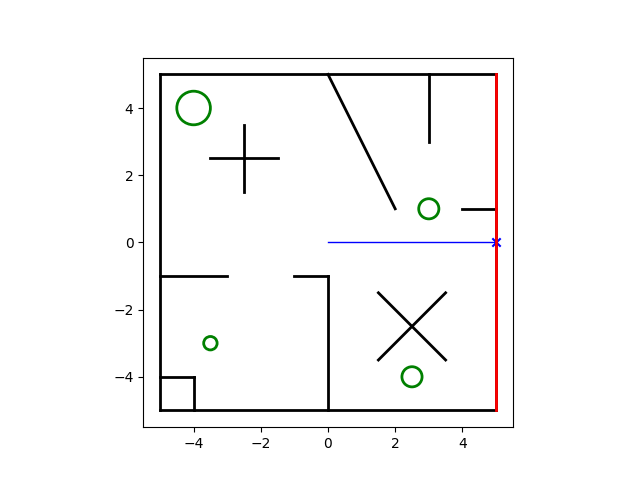

In [20]:
m = Map()

m.addSegments([
    #borders:
    Segment(Pose(-5, 5, Angle(0)), 10),
    Segment(Pose(5, 5, Angle(-90)), 10),
    Segment(Pose(-5, -5, Angle(0)), 10),
    Segment(Pose(-5, -5, Angle(90)), 10),

    #horizontal obstacles
    Segment(Pose(-5, -4, Angle(0)), 1),
    Segment(Pose(-5, -1, Angle(0)), 2),
    Segment(Pose(-1, -1, Angle(0)), 1),
    Segment(Pose(-3.5, 2.5, Angle(0)), 2),
    Segment(Pose(4, 1, Angle(0)), 1),

    #vertical obstacles
    Segment(Pose(-4  ,  -5, Angle(90)), 1),
    Segment(Pose( 0  ,  -5, Angle(90)), 4),
    Segment(Pose(-2.5, 1.5, Angle(90)), 2),
    Segment(Pose(3   ,   3, Angle(90)), 2),

    #oblique objects
    Segment(Pose(0, 5, Angle.arctan2(-4, 2)), np.sqrt(20)),
    Segment(Pose(1.5, -1.5, Angle.arctan2(-2, 2)), np.sqrt(8)),
    Segment(Pose(1.5, -3.5, Angle.arctan2( 2, 2)), np.sqrt(8)),
])

m.addMovingObjects([
    ObjectWithImage(Circle((3, 1), 0.3), r"./img/cat.png"),
    ObjectWithImage(Circle((-4, 4), 0.5), r"./img/cat.png"),
    ObjectWithImage(Circle((-3.5, -3), 0.2), r"./img/cat.png"),
    ObjectWithImage(Circle((2.5, -4), 0.3), r"./img/cat.png"),
])

#create an animation of a 360 scan of the map at the origin
clear_drawing = True #clears the axes before each draw of the new frame if True
x0, y0 = (0, 0)
n_frames = 200

f, ax = plt.subplots()

#update function for animation
def update(frame):
    if clear_drawing: ax.clear()
    m.draw(ax)
    ray = Segment(Pose(x0, y0, Angle(360 * frame / n_frames)), np.inf)
    distance, intersected_segment = m.findClosestIntersectionWith(ray, consider_objects=True)
    ray.length = distance

    x,y = ray.getCoordinates(distance)

    ray.draw(ax, color='b', linewidth=1)
    if clear_drawing: intersected_segment.draw(ax, color='r')
    if clear_drawing: ax.scatter([x],[y], color="b", marker="x", )

ani = FuncAnimation(f, update, frames=np.arange(0, n_frames), interval=50)

gif_path = 'img/2/mapScan.gif'
ani.save(gif_path, writer='pillow', fps=20)

plt.close(f)

display(Image(filename=gif_path))

## Beam-based Model of Range Finders

### Beam-based Measurements Modelation
The sensor model combines four probabilities to account for different measurement outcomes: hit, short, max, and rand.

1. **Hit Probability**:
    - The hit probability models the scenario where the sensor measurement is close to the expected value, accounting for noise.
    - Mathematically, it is given by:
      $$ p_{\text{hit}}(z_{\text{expected}}, z, \sigma_{\text{hit}}, z_{\text{max}}) = n \cdot \mathcal{N}(z \mid z_{\text{expected}}, \sigma_{\text{hit}}) $$
      where $ \mathcal{N}(z \mid z_{\text{expected}}, \sigma_{\text{hit}}) $ is the normal distribution:
      $$ \mathcal{N}(z \mid z_{\text{expected}}, \sigma_{\text{hit}}) = \frac{1}{\sqrt{2\pi\sigma_{\text{hit}}^2}} \exp\left(-\frac{(z - z_{\text{expected}})^2}{2\sigma_{\text{hit}}^2}\right) $$
      and $ n $ is the normalization factor ensuring the integral over $[0, z_{\text{max}}]$ is 1.

2. **Short Probability**:
    - The short probability models the scenario where the sensor measurement is shorter than the expected value.
    - Mathematically, it is given by:
      $$ p_{\text{short}}(z_{\text{expected}}, z, \lambda_{\text{short}}) = n \cdot \lambda_{\text{short}} \exp(-\lambda_{\text{short}} z) $$
      where $ n $ is:
      $$ n = \frac{1}{1 - \exp(-\lambda_{\text{short}} z_{\text{expected}})} $$

3. **Max Probability**:
    - The max probability models the scenario where the sensor measurement is equal to the maximum range.
    - Mathematically, it is given by:
      $$ p_{\text{max}}(z_{\text{expected}}, z, z_{\text{max}}) = \begin{cases} 1 & \text{if } |z_{\text{expected}} - z_{\text{max}}| < \epsilon \\ 0 & \text{otherwise} \end{cases} $$

4. **Rand Probability**:
    - The rand probability models the scenario where the sensor measurement is random.
    - Mathematically, it is given by:
      $$ p_{\text{rand}}(z_{\text{max}}) = \frac{1}{z_{\text{max}}} $$

The overall sensor model combines these probabilities as follows:
$$ p(z \mid z_{\text{expected}}, \sigma_{\text{hit}}, \lambda_{\text{short}}, z_{\text{max}}) = \alpha_{\text{hit}} p_{\text{hit}} + \alpha_{\text{short}} p_{\text{short}} + \alpha_{\text{max}} p_{\text{max}} + \alpha_{\text{rand}} p_{\text{rand}} $$

This combination allows the sensor model to account for different types of noise and measurement outcomes, providing a robust model for sensor measurements in robotics.


In [21]:
def p_hit(z_expected: float, z : float, deviation_hit : float,z_max : float, num_points : int = 10000):
  z_distribution = np.linspace(0,z_max,num_points)
  dz = z_max/(num_points-1)

  n = 1/(np.sum(normal_distribution(z_distribution,z_expected,deviation_hit))*dz)

  return n * normal_distribution(z,z_expected,deviation_hit)

def p_short(z_expected: float, z : float, lambda_short : float):
  n = 1/(1-np.exp(-lambda_short*z_expected))
  return n*lambda_short * np.exp(-lambda_short*z) if z_expected > z else 0

def p_max(z_expected: float, z : float, z_max, eps: float = 1e-6):
  return 1 if abs(z_expected - z_max) < eps else 0

def p_rand(z_max):
  return 1/z_max

### Beam-base learning parameters
The function `learn_intrinsic_parameters` is designed to learn the intrinsic parameters of a sensor model using maximum likelihood estimation:
$$ [\alpha_{\text{hit}}, \alpha_{\text{short}}, \alpha_{\text{max}}, \alpha_{\text{rand}}, \sigma_{\text{hit}}, \lambda_{\text{short}}] $$



In [22]:
def learn_intrinsic_parameters(Z : list[float], X : list[Pose],m : np.array,z_max: float,tol: float = 0.01,max_iter: int = 20) -> list[float]:
  last_deviation_hit = default_rng().uniform(0,1)
  last_lambda_short = default_rng().uniform(0,1)
  deviation_hit = last_deviation_hit
  lambda_short = last_lambda_short
  iter = 0
  while iter < max_iter:
    p = np.zeros((len(Z), 4))
    deviation_hit_nominator = np.zeros(len(Z))
    lambda_short_denominator = np.zeros(len(Z))
    for i, (z, xt) in enumerate(zip(Z, X)):
      z_expected = raycasting(xt, m)

      n = 1/(
              p_hit(z_expected,z,deviation_hit,z_max) +
              p_short(z_expected,z,lambda_short)+
              p_max(z_expected,z,z_max) +
              p_rand(z_max)
            )

      p[i, 0] = n * p_hit(z_expected,z,deviation_hit,z_max)  # p_hit
      p[i, 1] = n * p_short(z_expected,z,lambda_short)  # p_short
      p[i, 2] = n * p_max(z_expected,z,z_max)  # p_max
      p[i, 3] = n * p_rand(z_max)  # p_rand
      deviation_hit_nominator[i] = p[i, 0] * (z-z_expected)**2
      lambda_short_denominator[i] = p[i, 1] * z

    Z = np.array(Z)
    alfa_hit   = np.sum(p[:, 0])/np.linalg.norm(Z)
    alfa_short = np.sum(p[:, 1])/np.linalg.norm(Z)
    alfa_max   = np.sum(p[:, 2])/np.linalg.norm(Z)
    alfa_rand  = np.sum(p[:, 3])/np.linalg.norm(Z)
    deviation_hit = np.sqrt(np.sum(deviation_hit_nominator)/np.sum(p[:, 0]))
    lambda_short  = np.sum(p[:, 1])/np.sum(lambda_short_denominator)

    iter+=1
    if (abs(deviation_hit - last_deviation_hit) < tol and abs(lambda_short - last_lambda_short) < tol):
      break

  return [alfa_hit, alfa_short, max(1e-6, alfa_max), alfa_rand, deviation_hit, lambda_short]

Learned intrinsic parameters:
 alfa_hit: 8.1648
 alfa_short: 0.4077
 alfa_max: 0.0031
 alfa_rand: 0.4607
 deviation_hit: 0.0902
 lambda_short: 3.5535


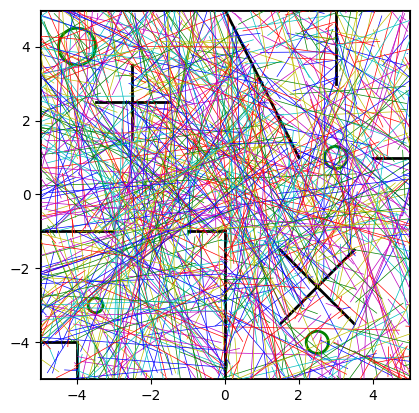

In [23]:
#compute raycasting data to compose Z, X
nb_meas = 1000

x_roi = (-5, 5)
y_roi = (-5, 5)

f, ax = plt.subplots()

ax.set_xlim(x_roi)
ax.set_ylim(y_roi)
m.draw(ax)

def sampleKMeasurementsRandomPosition(nb_meas: int, x_roi: tuple, y_roi: tuple, ax: plt.Axes | None = None, std_meas_noise: float = 0.1):
  Z = []
  X = []
  while len(Z) < nb_meas:
      x = default_rng().uniform(x_roi[0], x_roi[1])
      y = default_rng().uniform(y_roi[0], y_roi[1])
      orientation = Angle.from_radians(default_rng().uniform(0, 2 * np.pi))
      xt = Pose(x, y, orientation)

      z_expected = raycasting(xt, m)

      meas_noise = sample_normal_distribuition(std_meas_noise)
      while z_expected + meas_noise <= 0:
        meas_noise = sample_normal_distribuition(std_meas_noise)

      z_expected += meas_noise

      if z_expected < np.inf:
          random_color = default_rng().choice(['b', 'g', 'r', 'c', 'm', 'y'])
          Z.append(z_expected)
          X.append(xt)
          ray = Segment(xt, z_expected)
          if ax:
              ray.draw(ax,color=random_color, linewidth=0.5)
          else:
              print(f"Measurement: {z_expected}, Pose: {xt}")

  return Z, X

# train sensor model
Z, X = sampleKMeasurementsRandomPosition(nb_meas, x_roi, y_roi, ax=ax)

intrinsic_params = learn_intrinsic_parameters(Z, X, m, z_max=10, tol=0.01, max_iter=20)

print(f"Learned intrinsic parameters:"
      f"\n alfa_hit: {intrinsic_params[0]:.4f}"
      f"\n alfa_short: {intrinsic_params[1]:.4f}"
      f"\n alfa_max: {intrinsic_params[2]:.4f}"
      f"\n alfa_rand: {intrinsic_params[3]:.4f}"
      f"\n deviation_hit: {intrinsic_params[4]:.4f}"
      f"\n lambda_short: {intrinsic_params[5]:.4f}")


### Learned Sensor Model

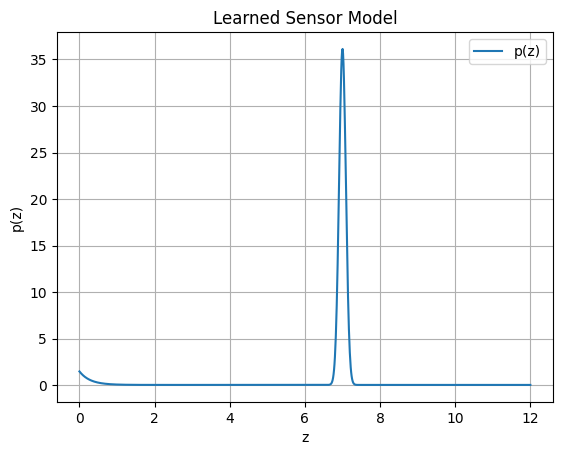

In [24]:
z_expected = 7
z_max = 12

alfa_hit, alfa_short, alfa_max, alfa_rand, deviation_hit, lambda_short = intrinsic_params

def p(z, z_expected): 
    return alfa_hit * p_hit(z_expected, z, deviation_hit, z_max) \
         + alfa_short * p_short(z_expected, z, lambda_short) \
         + alfa_max * p_max(z_expected, z, z_max) \
         + alfa_rand * p_rand(z_max)

z_values = np.linspace(0, z_max, 1000)

# Compute the probability p for each z in the range
p_values = [p(z, z_expected) for z in z_values]

# Plot the probabilities
f, ax = plt.subplots()
ax.plot(z_values, p_values, label='p(z)')
ax.set_xlabel('z')
ax.set_ylabel('p(z)')
ax.set_title('Learned Sensor Model')
ax.legend()
ax.grid(True)


### Beam-based Algorithm
The Beam Range Finder Model implements the raycasting and the intrinsic parameters found from the set of random mesaurements to return the likelyhood of a given measurement set of measurements. The likelyhood of a given set of measurements can then be used to compute ikelyhood maps showing where the robot is likely localized.  

In [25]:
def beam_range_finder_model(zt : list[float], xt_s : list[Pose], m : np.array,z_max : float,coefs : list[float] = [1.0,1.0,1.0,1.0,1.0,1.0]) -> float:
  measurement_lhood = 1
  for k in range(len(zt)):
    z = zt[k]
    xt = xt_s[k]

    z_expected = raycasting(xt, m)

    z_lhood = (
                coefs[0] * p_hit(z_expected,z,coefs[4],z_max) +
                coefs[1] * p_short(z_expected,z,coefs[5]) +
                coefs[2] * p_max(z_expected,z,z_max) +
                coefs[3] * p_rand(z_max)
              )
    measurement_lhood *= z_lhood
  return measurement_lhood

### Estimate the Robot's Position

This section describes how the robot's position is estimated using the beam-based model. The process involves computing the likelihood of measurements based on the sensor model and using this information to determine the robot's most likely position. The robot's position is estimated using a likelihood field, which is computed by evaluating the likelihood of sensor measurements at different positions in the environment. The position with the highest likelihood is chosen as the estimated position:

$$
x_{\text{est}} = \arg\max_{x} p(Z \mid x, m)
$$

#### Rasterize Map and Obstacel Map

To compare two methods for the estimation of the robot's pose, we need to rasterize the map and create an obstacle map consisting of a list of all coordinates occupied by an object. This is used to compare the Beam-based algorithm with the Scan-based algorithm. The fundamental difference between these two algorithms lies in the way the likelihood is computed:

- **Beam-based Algorithm**: Uses the probability of a given measurement for the computed set of sensor's intrinsic parameters.
- **Scan-based Algorithm**: Uses the Euclidean distance between the measurement endpoint and a given object in the map, which is minimized over all obstacles in the map.


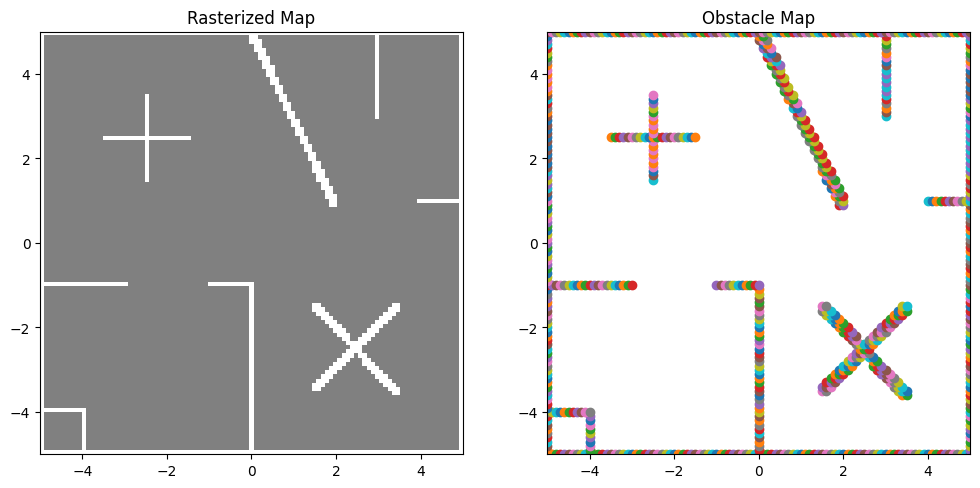

In [26]:
# ROI of map
x_roi = (-5, 5)
y_roi = (-5, 5)

#rasterize map in ROI to extract coordinates of pixels set to 1
resolution = 0.1
rm = m.rasterize(x_roi, y_roi, resolution=resolution)

# get coordinates of pixels set to 1
coords = np.array(np.where(rm == 1)).astype(float)
#shift in ROI
coords = coords * resolution + np.array([[y_roi[0]], [x_roi[0]]])
obstacle_map = list(zip(*coords))

#plot rasterized map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)

ax1.set_title('Rasterized Map')
ax1.imshow(rm, origin='lower', extent=(x_roi[0], x_roi[1], y_roi[0], y_roi[1]), cmap='gray', alpha=0.5, zorder=0)

ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)
ax2.set_aspect('equal')
ax2.set_title('Obstacle Map')

for y,x in obstacle_map: ax2.scatter(x,y)


<add_description_here>

In [27]:
d_sensor = 0.5
cos_th = d_sensor * np.cos(Angle(45))
sin_th = d_sensor * np.sin(Angle(45))

#robot initial position
x0 = 0
y0 = 0
th = Angle(45)

#define sensors and robot
sensors = [
    Pose(d_sensor , 0        , Angle(0)   ),
    Pose(cos_th   , sin_th   , Angle(45)  ),
    Pose(0        , d_sensor , Angle(90)  ),
    Pose(-cos_th  , sin_th   , Angle(135) ),
    Pose(-d_sensor, 0        , Angle(180) ),
    Pose(cos_th   , -sin_th  , Angle(-45) ),
    Pose(0        , -d_sensor, Angle(-90) ),
    Pose(-cos_th  , -sin_th  , Angle(-135)),
]

robot = Robot(Pose(x0, y0, th), sensors, m, shape = Circle((x0, y0), d_sensor))

# %% Plot map with robot and sensor readings

senor_readings = robot.getSensorReadings(std_meas_noise=0.5)

<add_description_here>

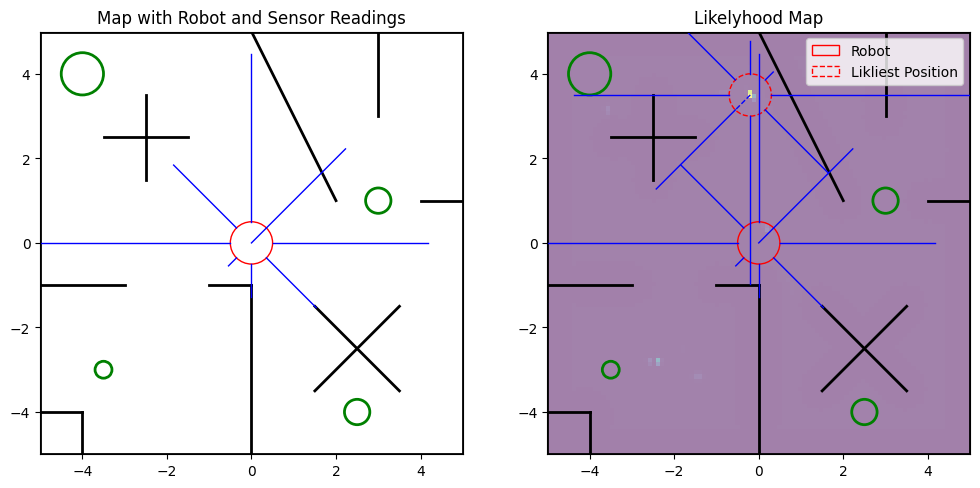

In [28]:
# Plot map with robot and sensor readings
senor_readings = robot.getSensorReadings(std_meas_noise=0.5)

# plot map with robot and sensor readings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)
ax1.set_title('Map with Robot and Sensor Readings')
m.draw(ax1)

robot.draw(ax1, linewidth=1, label="Robot")

#compute likelihood field
img=np.zeros_like(rm, dtype=float)

ny, nx = img.shape
n_alpha = 4
max_lh = -1.0
best_pose = None
for alpha in range(0,360, int(360 / n_alpha)):
  for x in range(nx):
    for y in range(ny):
      hypothesys = Pose(x * resolution + x_roi[0], y * resolution + y_roi[0], th + Angle(alpha))
      robot.updatePosition(hypothesys)

      if robot.isColliding():
        img[y, x] = -1.0
      else:
        lh = beam_range_finder_model(senor_readings, robot.getSensorPositions(), m, z_max=10, coefs=intrinsic_params)
        if lh > img[y, x]:
          img[y, x] = lh

        if lh > max_lh:
          max_lh = lh
          best_pose = hypothesys

robot.updatePosition(Pose(x0, y0, th))

# plot best estimated position on likelihood field
ax2.set_title('Likelyhood Map')
ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)

ax2.imshow(img, extent=(x_roi[0], x_roi[1], y_roi[0], y_roi[1]), origin='lower', alpha=0.5, zorder=0)
m.draw(ax2, draw_objects=True)
robot.draw(ax2, linewidth=1, label="Robot",)

robot.updatePosition(best_pose)
robot.draw(ax2, linewidth=1, label="Likliest Position", linestyle='--')

ax2.legend()

### Scan-based Model of Range Finders

In [29]:
def likelihood_field_range_finder_model(zt : list[float], robot : Robot, m : np.array, z_max : float, coefs : list[float] = [1.0,1.0,1.0,1.0,1.0,1.0]) -> float:
  sensors = robot.getSensorPositions()

  if len(zt) != len(sensors):
    raise ValueError("The number of measurements must match the number of sensor poses.")

  measurement_lhood = 1
  for k in range(len(zt)):
    z = zt[k]
    if z != z_max:
      s = sensors[k]

      mesuarement_x = s.x + z*(np.cos(s.orientation))
      mesuarement_y = s.y + z*(np.sin(s.orientation))

      min_dist = z_max

      for y, x in m:
        dist_obstacle = np.sqrt((x - mesuarement_x)**2 + (y - mesuarement_y)**2)

        if dist_obstacle < min_dist: min_dist = dist_obstacle

      measurement_lhood *= (coefs[0]*normal_distribution(0,min_dist,coefs[4])+coefs[3]/coefs[2])

  return measurement_lhood

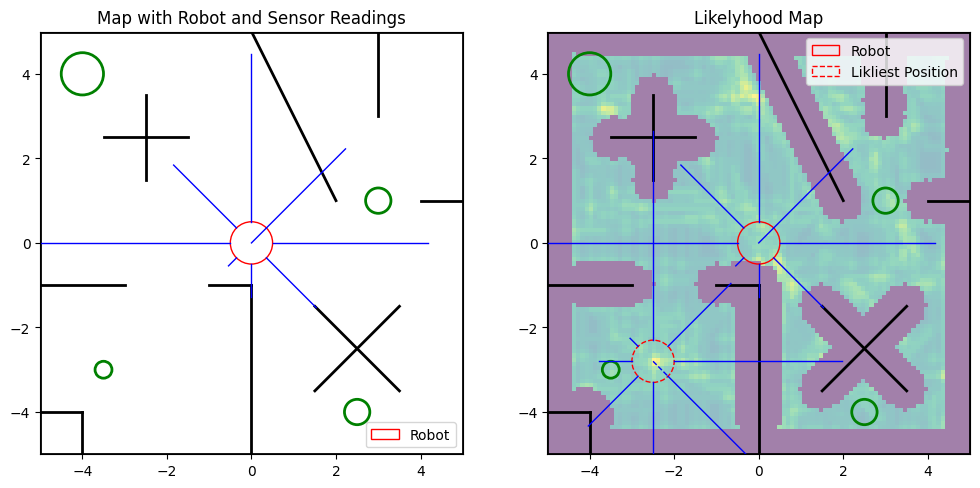

In [30]:
robot.updatePosition(Pose(x0, y0, th))

# plot map with robot and sensor readings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)
ax1.set_title('Map with Robot and Sensor Readings')
m.draw(ax1)

robot.draw(ax1, linewidth=1, label="Robot")

# %%
#compute likelihood field
img=np.zeros_like(rm, dtype=float)

ny, nx = img.shape
n_alpha = 4
max_lh = -1.0
best_pose = None
for alpha in range(0,360, int(360 / n_alpha)):
  for x in range(nx):
    for y in range(ny):
      hypothesys = Pose(x * resolution + x_roi[0], y * resolution + y_roi[0], th + Angle(alpha))
      robot.updatePosition(hypothesys)

      if robot.isColliding():
        img[y, x] = -1.0
      else:
        lh = likelihood_field_range_finder_model(senor_readings, robot, obstacle_map, z_max=10, coefs=intrinsic_params)
        if lh > img[y, x]:
          img[y, x] = lh

        if lh > max_lh:
          max_lh = lh
          best_pose = hypothesys

robot.updatePosition(Pose(x0, y0, th))

# plot best estimated position on likelihood field
ax2.set_title('Likelyhood Map')
ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)

ax2.imshow(img, extent=(x_roi[0], x_roi[1], y_roi[0], y_roi[1]), origin='lower', alpha=0.5, zorder=0)
m.draw(ax2, draw_objects=True)
robot.draw(ax2, linewidth=1, label="Robot",)

robot.updatePosition(best_pose)
robot.draw(ax2, linewidth=1, label="Likliest Position", linestyle='--')

ax1.legend()
ax2.legend()


## Feature-based Sensor Model with known correspondence
In this section, we consider a **feature-based sensor model** where the robot is able to
observe features in the environment and uniquely identify their correspondences.  
This means that each detected landmark measurement can be directly associated with a known map feature without ambiguity.

### Assumptions
- The robot moves in a 2D environment with features (landmarks) located at fixed known positions.  
- The measurement consists of the **range** (distance) and **bearing** (angle) relative to the robot's position.  
- Measurement noise is assumed to be **Gaussian**, with zero mean and known covariance.  
- The correspondences are given — i.e., there is no data association problem to solve.

### Mathematical Model
If the robot is at pose $(x, y, \theta)$ and observes a landmark at position $(x_f, y_f)$, the measurement prediction is:

$$
z = 
\begin{bmatrix}
r \\\\ \phi
\end{bmatrix}
=
\begin{bmatrix}
\sqrt{(x_f - x)^2 + (y_f - y)^2} \\\\
\arctan2(y_f - y, x_f - x) - \theta
\end{bmatrix}
$$

where:
- $r$ = expected range  
- $\phi$ = expected bearing  

The measurement noise is modeled as:

$$
z_{measured} = z + \mathcal{N}(0, Q)
$$

with covariance matrix $Q$.

### Target of the Following Code
The subsequent code cells implement this feature-based sensor model and simulate noisy measurements.
They generate the predicted range and bearing for landmarks, apply Gaussian noise, and return simulated sensor readings.


In [31]:
class Feature:
  def __init__(self, d : float,  angulation : Angle, s : int):
    self.d = d
    self.angulation = angulation
    self.s = s

  def __str__(self):
    return f"(d={self.d}, phi={self.angulation}, s={self.s})"


### Landmarks with Known Correspondence
A landmark with a known correspondence is a landmark which can be identified by its signature from the robot and from which position in the environment can be predicted/deduced by means of the map of landmarks.

In [32]:
def landmark_model_known_correspondence(f: Feature, c : int,  xt : Pose,m :np.array,coefs : list[float] = [1.0,1.0,1.0]):
  dx = m[c][0] - xt.x
  dy = m[c][1] - xt.y

  d_estimation = np.sqrt(dx**2 + dy**2)
  angle_estimation = Angle.arctan2(dy, dx) - xt.orientation

  lhood = normal_distribution(f.d - d_estimation,0,coefs[0]) * \
          normal_distribution(f.angulation-angle_estimation,0,coefs[1]) * \
          normal_distribution(f.s-m[c][3],0,coefs[2])

  return lhood

### Visualization of the Robot Localization
In the following plot, the likelyhood distribution of the robot's position is plotted given a set of landmarks that are detected, their correspondences being the index of the landmark in the landmark map and a list of landmarks which serves as landmark map. The brighter the pixel, the more likely the position of the robot. The actual position estimate is then placed at the location of maximum likelyhood

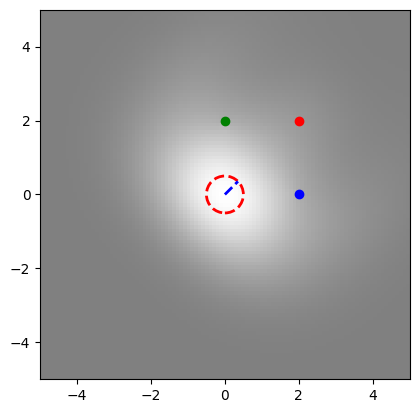

In [33]:
#robot initial position
x0 = 0
y0 = 0
th = Angle(45)

robot.sensor_readings = [0] * len(robot.sensors)

# Define landmarks
landmarks = [
    Feature(2*np.sqrt(2), Angle(0), 1),
    Feature(2, Angle(-45), 2),
    Feature(2, Angle(45), 3),
]

# Correspondence vector (index of the landmark for each measurement)
correspondence = [0, 1, 2]

# Initialize the map with landmarks
landmark_map = np.array([
    #x, y,  th,   s
    [2, 2, 0.0, 1.0],
    [2, 0, 0.0, 2.0],
    [0, 2, 0.0, 3.0],
])

# Initialize the feature-based sensor model parameters
coefs = [1.0, 1.0, 1.0]

# Compute the likelihood for each feature measurement
img=np.zeros_like(rm, dtype=float)

ny, nx = img.shape
for x in range(nx):
  for y in range(ny):
      robot.updatePosition(Pose(x * resolution + x_roi[0], y * resolution + y_roi[0], th))

      for l, c in zip(landmarks, correspondence):
        img[y, x] += landmark_model_known_correspondence(l, c, robot.pos, landmark_map, coefs)

robot.updatePosition(Pose(x0, y0, th))

#get best estimated position
best_pos = np.unravel_index(np.argmax(img, axis=None), img.shape)
best_x = best_pos[1] * resolution + x_roi[0]
best_y = best_pos[0] * resolution + y_roi[0]

# plot best estimated position on likelihood field
f, ax = plt.subplots()

ax.set_xlim(x_roi)
ax.set_ylim(y_roi)

ax.imshow(img / np.max(img), extent=(x_roi[0], x_roi[1], y_roi[0], y_roi[1]), origin='lower', cmap='gray', alpha=0.5, zorder=0)

i=0
for l in landmark_map:
    x_landmark = l[0]
    y_landmark = l[1]
    ax.scatter(x_landmark, y_landmark, color=(['r', 'b', 'g'])[i], marker='o', label=f'Landmark (s={int(l[3])})')
    i += 1
#plotRobot2D(ax, robot_pose.x, robot_pose.y, robot_pose.orientation, r=0.5, linestyle='-', label="Robot")

robot.updatePosition(Pose(best_x, best_y, robot.pos.orientation))

robot.draw(ax, linestyle='--', label="Estimated Position")




### Landmarks with Known Correspondence Sample Method
Another approach to localizing the robot when the correspondence is known is by sampling points around the landmark and compute the histogram over the ROI. This allows to palce the estimate of the robot's position at the coordinate where the histogram peaks. 

In [34]:
def sample_landmark_model_known_correspondence(f: Feature, c : int,m :np.array,coefs : list[float] = [1.0,1.0,1.0]):
  initial_angle_estimation = Angle.from_radians(default_rng().uniform(0,2*np.pi))

  d_estimation = f.d + sample_normal_distribuition(coefs[0])
  angle_estimation = f.angulation + sample_normal_distribuition(coefs[1])


  xt = Pose(
      m[c][0] + d_estimation * np.cos(initial_angle_estimation),
      m[c][1] + d_estimation * np.sin(initial_angle_estimation),
      initial_angle_estimation - np.pi - angle_estimation
  )
  return xt

### Visualization of the Sample Method
Given the landmarks as shown below, the samples are generated all around the measured landmarks. The histogramm is thed computed from the denisty of samples in a given bin of the raster.

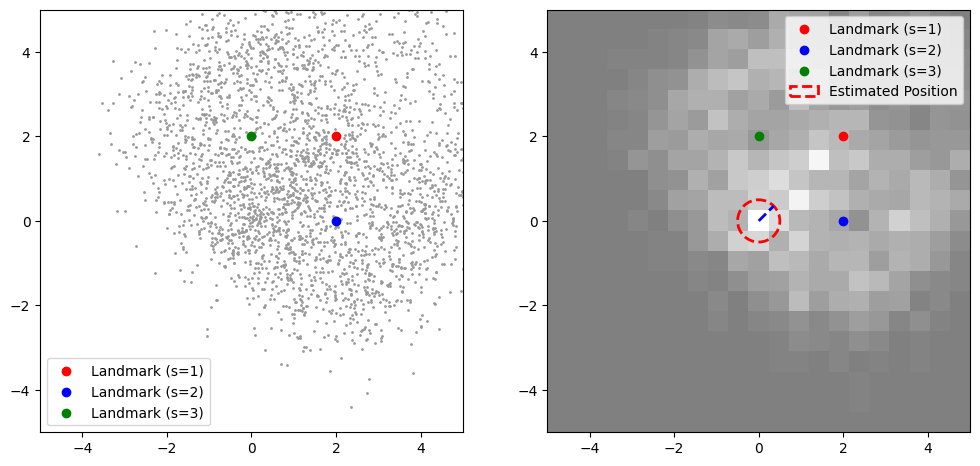

In [35]:
# Initialize the feature-based sensor model parameters
coefs = [0.7, 0.01, 1.0]

# Compute the likelihood for each feature measurement
n_samples = 1000
samples = []
for i in range(n_samples):
  for l, c in zip(landmarks, correspondence):
    x_sample = sample_landmark_model_known_correspondence(l, c, landmark_map, coefs)

    samples.append([x_sample.x,x_sample.y])

samples = np.array(samples)

# plot the sampled points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_xlim(x_roi)
ax1.set_ylim(y_roi)

ax1.scatter(samples[:,0],samples[:,1], s=1, color="#999")

i=0
for l in landmark_map:
    x_landmark = l[0]
    y_landmark = l[1]
    ax1.scatter(x_landmark, y_landmark, color=(['r', 'b', 'g'])[i], marker='o', label=f'Landmark (s={int(l[3])})')
    i += 1

# plot the 2D histogram of the samples to deduce best position estimate
def round_to_resolution(x: np.ndarray, r: float):
  return np.round(x / r) * r

#set bin resolution
resolution = 0.5

rounded_samples = round_to_resolution(samples, resolution)

#create image for 2D histogram
x_min, x_max = x_roi
y_min, y_max = y_roi

nx = int((x_max - x_min) / resolution + 1)
ny = int((y_max - y_min) / resolution + 1)

img = np.zeros((ny, nx), dtype=float)

#compute histogram
ny, nx = img.shape
for x in range(nx):
  for y in range(ny):
    xx, yy = x * resolution + x_roi[0], y * resolution + y_roi[0]

    count = np.sum((rounded_samples[:, 0] == xx) & (rounded_samples[:, 1] == yy))
    img[y, x] = count

#get best estimated position
best_pos = np.unravel_index(np.argmax(img, axis=None), img.shape)
best_x = best_pos[1] * resolution + x_roi[0]
best_y = best_pos[0] * resolution + y_roi[0]

ax2.set_xlim(x_roi)
ax2.set_ylim(y_roi)

ax2.imshow(img / np.max(img), extent=(x_roi[0], x_roi[1], y_roi[0], y_roi[1]), origin='lower', cmap='gray', alpha=0.5, zorder=0)

i=0
for l in landmark_map:
    x_landmark = l[0]
    y_landmark = l[1]
    ax2.scatter(x_landmark, y_landmark, color=(['r', 'b', 'g'])[i], marker='o', label=f'Landmark (s={int(l[3])})')
    i += 1

robot.updatePosition(Pose(best_x, best_y, robot.pos.orientation))

robot.draw(ax2, linestyle='--', label="Estimated Position")

ax1.set_aspect('equal', adjustable='box')
ax1.legend()
ax2.legend()